## **1. 구글 드라이브 마운트**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2. 패키지 임포트**

In [ ]:
!pip install pycocotools --quiet
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install -U git+https://github.com/albu/albumentations > /dev/null 
!git clone https://github.com/pytorch/vision.git
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

     |████████████████████████████████| 98 kB 3.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-b5jlbjfg
Cloning into 'vision'...
remote: Enumerating objects: 39654, done.
remote: Counting objects: 100% (5152/5152), done.
remote: Compressing objects: 100% (1410/1410), done.
remote: Total 39654 (delta 4001), reused 4663 (delta 3630), pack-reused 34502
Receiving objects: 100% (39654/39654), 52.92 MiB | 26.56 MiB/s, done.
Resolving deltas: 100% (30535/30535), done.
fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import cv2
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

# For image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# As the data directory contains .xml files
from xml.etree import ElementTree as et

import warnings
warnings.filterwarnings('ignore')

## **3. 경로설정**

In [ ]:
# defining the files directory and testing directory
files_dir = '/content/drive/MyDrive/객체탐지/trainrice'
test_dir = '/content/drive/MyDrive/객체탐지/testrice'

## **4. 바운딩 박스 시각화 데이터셋 생성 (좌표정보, 클래스 이름 정의)**

In [ ]:
class RiceImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, files_dir, width, height, transforms=None):
        self.files_dir = files_dir
        self.width = width
        self.height = height
        self.transforms = transforms  # If transformation is required, when transforms is not None
        
        self.classes_ = [_, 'rottenrice']  # Defining classes, a blank class is given for the background
        
        self.images = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.files_dir, img_name)
        
        # Reading the image
        img = cv2.imread(img_path)
        
        # Defining width and height
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Converting image to RGB channel and normalizing the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.files_dir, annot_name)
        
        # Boxes to store the coordinate points of the bboxes
        boxes, labels = [], []
        
        tree = et.parse(annot_path)
        root = tree.getroot()
        
        # Box coordinates are extracted from the XML files for the given image size
        for member in root.findall('object'):
            labels.append(self.classes_.index(member.find('name').text))
            
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
        # Conversion to Tensors   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # Calculating area of the boxes
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}
        
        if self.transforms:
            sample = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img, target

#### 4-1. 별도의 변형 없이 데이터셋 정의 및 확인

In [ ]:
dataset = RiceImageDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  40 



#### 4-2. 특정 데이터셋에 해당하는 img, target 정의

In [ ]:
img, target = dataset[1]
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[118.8889, 145.2778, 142.9630, 161.7222],
        [146.3704, 151.7778, 174.1481, 169.8333],
        [191.7778, 135.7778, 218.2963, 158.0000]]), 'area': tensor([395.8852, 501.5431, 589.3007]), 'labels': tensor([1, 1, 1]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([1])}


## **5. 바운딩박스 시각화**
#### 5-1. 시각화 사용자 정의 함수 생성

In [ ]:
def plot_img_bbox(img, target):
    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

#### 5-2.시각화 결과

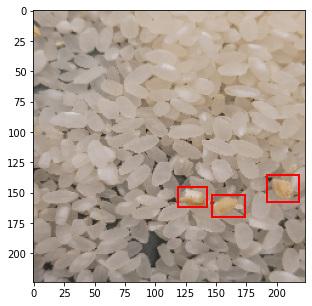

In [ ]:
img, target = dataset[1]
plot_img_bbox(img, target)

## **6.전처리**
#### 6-1.사전 학습 모델 사용자 정의함수 생성

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
dataset = RiceImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = RiceImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# 7. 모델 생성

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

model = get_object_detection_model(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# training for 10 epochs
num_epochs = 10

for epoch in range(1,11):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [ ]:
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
img, target = dataset_test[7]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
test_dataset = RiceImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[7]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)